In [820]:
import numpy as np
import requests
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.feature_selection as seleccion
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [2]:
dfFinal = pd.read_csv('dfFinalPlusCorrect.csv', low_memory = False)
dfFinal

,Player,personId,Temporada,Salarios,playerteamName,assists,blocks,fieldGoalsAttempted,fieldGoalsMade,foulsPersonal,...,threePointersMade,turnovers,height,Posicion,age,playerValue,minuteValue,SalarioEstadisticas,TemporadaAnterior,playerteamName_Anterior
0,Stephen Curry,201939,2023-2024,55761217.0,Warriors,393.0,32.0,1504.0,678.0,120.0,...,373.0,226.0,74.0,Guard,36.0,1144.0,0.458333,53458234,2022-2023,Warriors
1,Nikola Jokic,203999,2023-2024,51415938.0,Nuggets,831.0,78.0,1700.0,982.0,236.0,...,102.0,285.0,83.0,Center,29.0,3178.0,0.973950,49021953,2022-2023,Nuggets
2,Joel Embiid,203954,2023-2024,51415938.0,76ers,259.0,77.0,1013.0,518.0,137.0,...,70.0,181.0,84.0,Forward,30.0,1507.0,0.938941,49021953,2022-2023,76ers
3,Kevin Durant,201142,2023-2024,51179020.0,Suns,404.0,97.0,1549.0,812.0,143.0,...,179.0,260.0,82.0,Forward,36.0,1852.0,0.620228,49065286,2022-2023,Nets
4,Bradley Beal,203078,2023-2024,50203930.0,Suns,288.0,28.0,806.0,408.0,142.0,...,112.0,146.0,76.0,Guard,31.0,810.0,0.421217,48130468,2022-2023,Wizards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,Jordan McLaughlin,1629162,2019-2020,613928.0,Timberwolves,128.0,4.0,178.0,87.0,31.0,...,29.0,36.0,72.0,Guard,24.0,229.0,0.390785,97595,2018-2019,Nets
1168,Landry Shamet,1629013,2019-2020,2547113.0,Clippers,122.0,13.0,475.0,189.0,163.0,...,129.0,59.0,76.0,Guard,23.0,119.0,0.068000,2447136,2018-2019,76ers
1169,Eric Bledsoe,202339,2019-2020,20565418.0,Bucks,383.0,32.0,804.0,374.0,149.0,...,83.0,173.0,73.0,Guard,31.0,860.0,0.455267,19165014,2018-2019,Bucks
1170,PJ Dozier,1628408,2019-2020,2148304.0,Nuggets,79.0,8.0,207.0,87.0,62.0,...,19.0,39.0,78.0,Guard,24.0,138.0,0.251825,224601,2018-2019,Celtics


Primero nos quedamos con las columnas que nos interesan del data frame

In [4]:
dfFinal = dfFinal.iloc[:,3:]
dfFinal.pop('TemporadaAnterior')
dfFinal.columns

Index(['Salarios', 'playerteamName', 'assists', 'blocks',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'foulsPersonal',
       'freeThrowsAttempted', 'freeThrowsMade', 'numMinutes',
       'plusMinusPoints', 'points', 'reboundsTotal', 'steals',
       'threePointersAttempted', 'threePointersMade', 'turnovers', 'height',
       'Posicion', 'age', 'playerValue', 'minuteValue', 'SalarioEstadisticas',
       'playerteamName_Anterior'],
      dtype='object')

In [5]:
# Seleccionar las columnas numéricas que utilizaremos para varias  a normalizar que tendremos 
numFeatures = ['assists', 'blocks','fieldGoalsAttempted', 'fieldGoalsMade', 'foulsPersonal',
       'freeThrowsAttempted', 'freeThrowsMade', 'numMinutes','plusMinusPoints', 'points', 'reboundsTotal', 'steals',
       'threePointersAttempted', 'threePointersMade', 'turnovers', 'height', 'age', 'playerValue', 'minuteValue', 'SalarioEstadisticas']


Filtramos un poco más y estudiamos como se distribuyen las variables

Vamos a ver las medidas estadisticas de los principales features sin normalizar:

In [12]:
# Medidas estadísticas básicas de las variables numéricas
estadisticas = dfFinal.loc[:,numFeatures].describe()
estadisticasSalario = dfFinal.loc[:,['Salarios']].describe()

# Calcular medidas adicionales
moda = dfFinal.loc[:,numFeatures].mode().iloc[0]  # Moda

varianza = dfFinal.loc[:,numFeatures].var()  # Varianza
varianzaSalario = dfFinal.loc[:,['Salarios']].var()

desviacion = dfFinal.loc[:,numFeatures].std()  # Desviación estándar

coef_variacion = dfFinal.loc[:,numFeatures].std() / dfFinal.loc[:,numFeatures].mean()  # Coeficiente de variación
coef_variacionSalario = dfFinal.loc[:,['Salarios']].std() / dfFinal.loc[:,['Salarios']].mean()

In [14]:
print(f"Estadísticas básicas (numFeatures):\n{estadisticas}")
print(f"\nEstadísticas de Salarios:\n{estadisticasSalario}")

print(f"\nModa (numFeatures):\n{moda}")

print(f"\nVarianza (numFeatures):\n{varianza}")
print(f"\nVarianza de Salarios:\n{varianzaSalario}")

print(f"\nDesviación estándar (numFeatures):\n{desviacion}")

print(f"\nCoeficiente de variación (numFeatures):\n{coef_variacion}")
print(f"\nCoeficiente de variación de Salarios:\n{coef_variacionSalario}")


Estadísticas básicas (numFeatures):
           assists       blocks  fieldGoalsAttempted  fieldGoalsMade  \
count  1172.000000  1172.000000          1172.000000     1172.000000   
mean    177.403584    32.402730           599.246587      285.866894   
std     161.928435    32.636443           432.083086      208.868681   
min       0.000000     0.000000             0.000000        0.000000   
25%      60.000000    10.000000           251.500000      117.000000   
50%     126.000000    22.000000           527.500000      252.000000   
75%     255.250000    45.000000           852.000000      405.000000   
max     905.000000   223.000000          2182.000000     1042.000000   

       foulsPersonal  freeThrowsAttempted  freeThrowsMade   numMinutes  \
count    1172.000000          1172.000000     1172.000000  1172.000000   
mean      123.790102           162.243174      127.633106  1532.354096   
std        69.240126           158.544247      129.340818   859.913431   
min         0.00000

Como podemos ver en las medidas sacadas, nuestor set de datos tiene una varianza y una desviacion muy alta debido a que el data set lo hemos creado nosotros a partir de diferentes archivos de datos y son los datos que tenemos completos. Vamos a visualizar también los Salarios de contratación de nuestro set de datos para ver que efectivamente hay muchos datos que se alejan de la mediana (y por lo tanto nos da una grafica de densidad muy amplia en los extremos).

Distribución de los salarios:

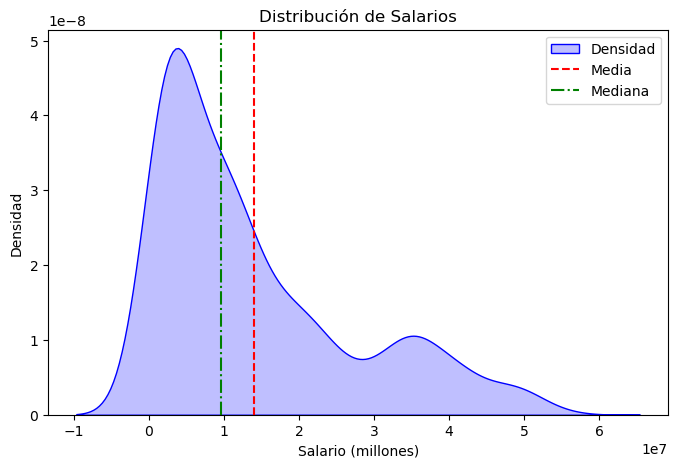

In [18]:

plt.figure(figsize=(8, 5))
sns.kdeplot(dfFinal['Salarios'], fill=True, color="blue", label="Densidad")
plt.axvline(dfFinal['Salarios'].mean(), color='red', linestyle='--', label='Media')
plt.axvline(dfFinal['Salarios'].median(), color='green', linestyle='-.', label='Mediana')

plt.title('Distribución de Salarios')
plt.xlabel('Salario (millones)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Grafico de bigotes:

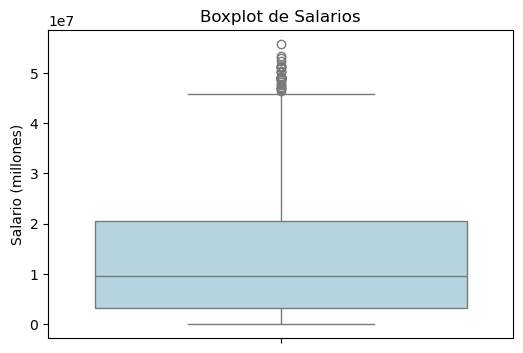

In [21]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=dfFinal['Salarios'], color="lightblue")
plt.title('Boxplot de Salarios')
plt.ylabel('Salario (millones)')
plt.show()

Interpretación de la Distribución de Salarios

Forma de la distribución:

La distribución es asimétrica positiva (sesgada a la derecha).
La mayor densidad de salarios está en valores bajos, mientras que hay una larga cola hacia la derecha.
Esto indica que la mayoría de los jugadores tienen salarios relativamente bajos, pero hay algunos con salarios extremadamente altos (posibles outliers).

Diferencia entre la media y la mediana:

La media (línea roja discontinua) está más a la derecha que la mediana (línea verde punteada).
Esto es una señal de que los outliers (salarios muy altos) están elevando el valor medio.
En distribuciones normales, la media y la mediana deberían estar alineadas; aquí, la diferencia indica que hay jugadores con contratos muy altos que influyen en el promedio.

Posibles outliers:

La presencia de valores atípicos (jugadores con salarios muy elevados) es clara porque hay una cola larga hacia la derecha.
Esto puede distorsionar análisis y modelos predictivos, por lo que podríamos considerar eliminar outliers usando el IQR (rango intercuartílico) o algún otro método de detección.


Vamos a probar a eliminar los 'outliers' que nos pueden perjudicar en el modelo 

# Eliminacion de outliers por el método IQR

El IQR (Interquartile Range) es una técnica que define los outliers como valores que están por debajo del primer cuartil (Q1 - 1.5 * IQR) o por encima del tercer cuartil (Q3 + 1.5 * IQR).

In [27]:
# Calcular cuartiles y IQR
Q1 = dfFinal['Salarios'].quantile(0.25)
Q3 = dfFinal['Salarios'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
limiteInferior = Q1 - 1.5 * IQR
limiteSuperior = Q3 + 1.5 * IQR

# Filtrar el DataFrame sin outliers
dfNoOutliers = dfFinal[(dfFinal['Salarios'] >= limiteInferior) & (dfFinal['Salarios'] <= limiteSuperior)]


In [29]:
dfNoOutliers

,Salarios,playerteamName,assists,blocks,fieldGoalsAttempted,fieldGoalsMade,foulsPersonal,freeThrowsAttempted,freeThrowsMade,numMinutes,...,threePointersAttempted,threePointersMade,turnovers,height,Posicion,age,playerValue,minuteValue,SalarioEstadisticas,playerteamName_Anterior
13,44531940.0,Bulls,107.0,8.0,417.0,192.0,62.0,105.0,90.0,929.0,...,185.0,64.0,58.0,77.0,Guard,29.0,338.0,0.363832,41254687,Bulls
14,43827586.0,Timberwolves,129.0,181.0,735.0,481.0,299.0,480.0,310.0,3145.0,...,4.0,0.0,144.0,85.0,Center,32.0,1937.0,0.615898,42218272,Timberwolves
15,43219440.0,Lakers,301.0,204.0,1459.0,817.0,212.0,590.0,479.0,3029.0,...,125.0,35.0,181.0,82.0,Forward,31.0,2615.0,0.863321,41806469,Lakers
16,43031940.0,Hawks,616.0,11.0,1071.0,458.0,114.0,437.0,374.0,2035.0,...,503.0,187.0,256.0,73.0,Guard,26.0,977.0,0.480098,41254687,Hawks
17,43031940.0,Mavericks,871.0,46.0,2182.0,1042.0,206.0,775.0,607.0,3516.0,...,970.0,357.0,377.0,79.0,Guard,25.0,2468.0,0.701934,41254687,Mavericks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,613928.0,Timberwolves,128.0,4.0,178.0,87.0,31.0,41.0,28.0,586.0,...,76.0,29.0,36.0,72.0,Guard,24.0,229.0,0.390785,97595,Nets
1168,2547113.0,Clippers,122.0,13.0,475.0,189.0,163.0,84.0,71.0,1750.0,...,355.0,129.0,59.0,76.0,Guard,23.0,119.0,0.068000,2447136,76ers
1169,20565418.0,Bucks,383.0,32.0,804.0,374.0,149.0,241.0,190.0,1889.0,...,248.0,83.0,173.0,73.0,Guard,31.0,860.0,0.455267,19165014,Bucks
1170,2148304.0,Nuggets,79.0,8.0,207.0,87.0,62.0,51.0,36.0,548.0,...,60.0,19.0,39.0,78.0,Guard,24.0,138.0,0.251825,224601,Celtics


Comparamos ahora la distribución de densidad con y sin outliers

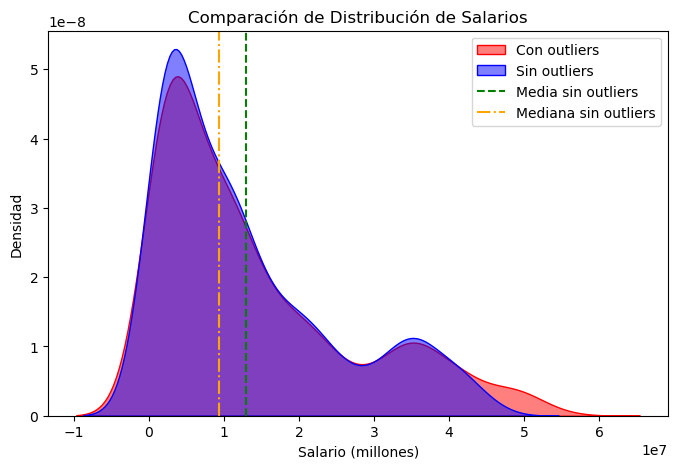

In [32]:
plt.figure(figsize=(8, 5))

# Distribución con outliers
sns.kdeplot(dfFinal['Salarios'], fill=True, color="red", label="Con outliers", alpha=0.5)
# Distribución sin outliers
sns.kdeplot(dfNoOutliers['Salarios'], fill=True, color="blue", label="Sin outliers", alpha=0.5)

plt.axvline(dfNoOutliers['Salarios'].mean(), color='green', linestyle='--', label='Media sin outliers')
plt.axvline(dfNoOutliers['Salarios'].median(), color='orange', linestyle='-.', label='Mediana sin outliers')

plt.title('Comparación de Distribución de Salarios')
plt.xlabel('Salario (millones)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

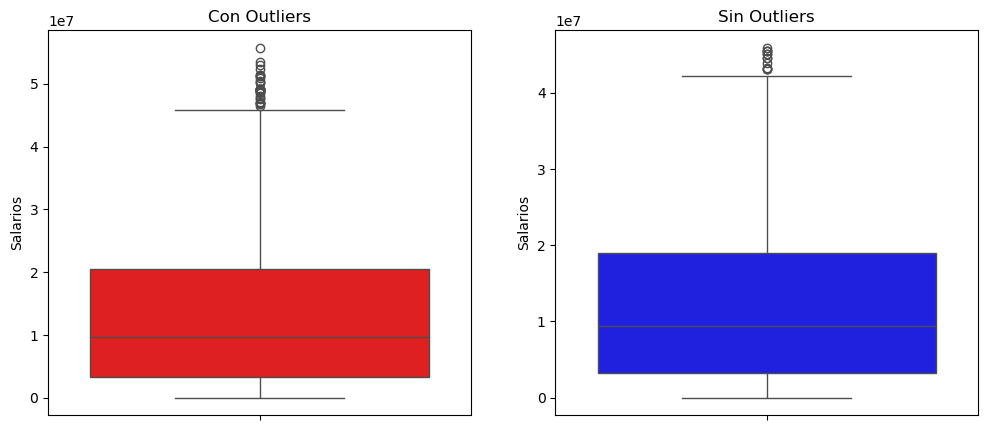

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot con outliers
sns.boxplot(y=dfFinal['Salarios'], ax=axes[0], color="red")
axes[0].set_title("Con Outliers")

# Boxplot sin outliers
sns.boxplot(y=dfNoOutliers['Salarios'], ax=axes[1], color="blue")
axes[1].set_title("Sin Outliers")

plt.show()

Como sigue estando muy sesgado, vamos a intentar hacer una transformación logarítmica

# Transformación logarítmica para reducir el sesgo

Lo vamos a hacer desde el data set sin los outliers

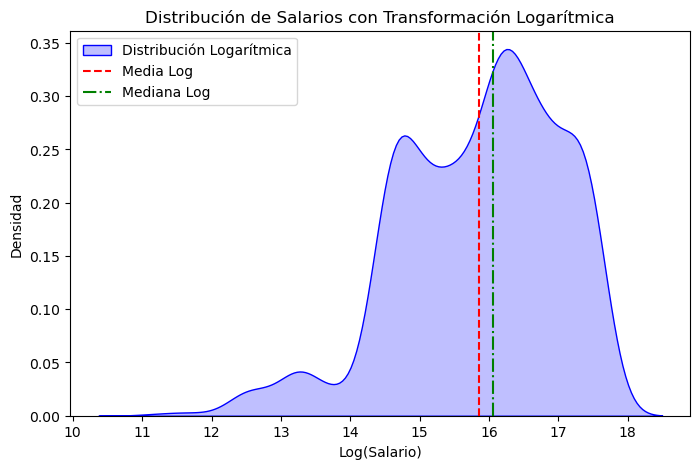

In [39]:

# Aplicamos logaritmo natural para transformar los salarios
dfNoOutliers = dfNoOutliers[dfNoOutliers['Salarios'] > 0].copy()  # Asegura una copia independiente
dfNoOutliers.loc[:, 'LogSalario'] = np.log(dfNoOutliers['Salarios'])


# Graficamos la nueva distribución
plt.figure(figsize=(8,5))
sns.kdeplot(dfNoOutliers['LogSalario'], fill=True, color="blue", label="Distribución Logarítmica")
plt.axvline(dfNoOutliers['LogSalario'].mean(), color='red', linestyle='--', label='Media Log')
plt.axvline(dfNoOutliers['LogSalario'].median(), color='green', linestyle='-.', label='Mediana Log')

plt.title("Distribución de Salarios con Transformación Logarítmica")
plt.xlabel("Log(Salario)")
plt.ylabel("Densidad")
plt.legend()
plt.show()

La distribución por cajas se nos quedaría así:

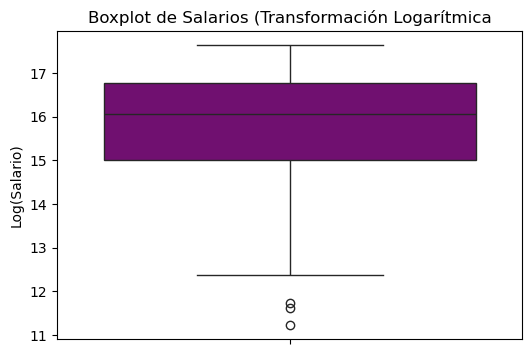

In [42]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=dfNoOutliers['LogSalario'], color="purple")
plt.title('Boxplot de Salarios (Transformación Logarítmica')
plt.ylabel('Log(Salario)')
plt.show()

Esta distribución es mejor, así que emplearemos la variable LogSalario como Y a predecir y, como los salarios de estadisticas también estan sesgados creamos una columna con su logaritmo

In [45]:
# Aplicamos logaritmo natural para transformar los salarios
dfNoOutliers = dfNoOutliers[dfNoOutliers['SalarioEstadisticas'] > 0].copy()  # Asegura una copia independiente
dfNoOutliers.loc[:, 'LogSalarioEstadisticas'] = np.log(dfNoOutliers['SalarioEstadisticas'])

In [47]:
dfNoOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1130 entries, 13 to 1171
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Salarios                 1130 non-null   float64
 1   playerteamName           1130 non-null   object 
 2   assists                  1130 non-null   float64
 3   blocks                   1130 non-null   float64
 4   fieldGoalsAttempted      1130 non-null   float64
 5   fieldGoalsMade           1130 non-null   float64
 6   foulsPersonal            1130 non-null   float64
 7   freeThrowsAttempted      1130 non-null   float64
 8   freeThrowsMade           1130 non-null   float64
 9   numMinutes               1130 non-null   float64
 10  plusMinusPoints          1130 non-null   float64
 11  points                   1130 non-null   float64
 12  reboundsTotal            1130 non-null   float64
 13  steals                   1130 non-null   float64
 14  threePointersAttempted   113

Por último, antes de hacer el modelo, vemos las estadisticas del Data Frame final  

In [50]:
numFeatures1 = numFeatures + ['LogSalario'] + ['LogSalarioEstadisticas']  # Añadimos los logaritmos

In [52]:
numFeatures1

['assists',
 'blocks',
 'fieldGoalsAttempted',
 'fieldGoalsMade',
 'foulsPersonal',
 'freeThrowsAttempted',
 'freeThrowsMade',
 'numMinutes',
 'plusMinusPoints',
 'points',
 'reboundsTotal',
 'steals',
 'threePointersAttempted',
 'threePointersMade',
 'turnovers',
 'height',
 'age',
 'playerValue',
 'minuteValue',
 'SalarioEstadisticas',
 'LogSalario',
 'LogSalarioEstadisticas']

In [54]:
# Medidas estadísticas básicas de las variables numéricas
estadisticas1 = dfNoOutliers.loc[:,numFeatures1].describe()
estadisticasSalario1 = dfNoOutliers.loc[:,['LogSalario']].describe()

# Calcular medidas adicionales
moda1 = dfNoOutliers.loc[:, numFeatures1].mode().iloc[0]  # Moda

varianza1 = dfNoOutliers.loc[:, numFeatures1].var()  # Varianza
varianzaSalario1 = dfNoOutliers.loc[:, ['LogSalario']].var()

desviacion1 = dfNoOutliers.loc[:, numFeatures1].std()  # Desviación estándar

coef_variacion1 = dfNoOutliers.loc[:, numFeatures1].std() / dfNoOutliers.loc[:, numFeatures1].mean()  # Coeficiente de variación
coef_variacionSalario1 = dfNoOutliers.loc[:, ['LogSalario']].std() / dfNoOutliers.loc[:, ['LogSalario']].mean()

In [56]:
print(f"Estadísticas básicas (numFeatures1):\n{estadisticas1}")
print(f"\nEstadísticas de LogSalario:\n{estadisticasSalario1}")
print(f"\nModa (numFeatures1):\n{moda1}")
print(f"\nVarianza (numFeatures1):\n{varianza1}")
print(f"\nVarianza de LogSalario:\n{varianzaSalario1}")
print(f"\nDesviación estándar (numFeatures1):\n{desviacion1}")
print(f"\nCoeficiente de variación (numFeatures1):\n{coef_variacion1}")
print(f"\nCoeficiente de variación de LogSalario:\n{coef_variacionSalario1}")

Estadísticas básicas (numFeatures1):
           assists       blocks  fieldGoalsAttempted  fieldGoalsMade  \
count  1130.000000  1130.000000          1130.000000     1130.000000   
mean    171.095575    32.092035           582.777876      276.854867   
std     155.177739    32.667887           417.105706      199.469008   
min       0.000000     0.000000             0.000000        0.000000   
25%      59.000000    10.000000           249.250000      117.000000   
50%     124.000000    22.000000           512.500000      248.000000   
75%     242.000000    44.000000           819.750000      386.000000   
max     903.000000   223.000000          2182.000000     1042.000000   

       foulsPersonal  freeThrowsAttempted  freeThrowsMade   numMinutes  \
count    1130.000000          1130.000000     1130.000000  1130.000000   
mean      123.527434           154.207080      120.792035  1515.654867   
std        68.823310           148.132226      120.382819   848.621274   
min         0.0000

# Filtrado de datos y features para el modelo 

Seleccionamos features que nos interesen, para resumir todas las características de juego utilizamos la columna PlayerValue, ya que es una cálculo que se utiliza en la ACB para medir la calidad de juego (puntos, triples, bloqueos, asistencias...) y podemos prescindir de una gran cantidad de columnas que tenemos en nuestro set.

Además, intuitivamente podemos ver que el equipo en el que el jugador jugó el año anterior, el salario que tenía durante esa temporada, la edad en el año de contratación y la altura, pueden ser variables decisivas a la hora de predecir el salario en el año posterior de ese jugador.

Así que solo nos quedamos con algunas de las columnas.

In [502]:
dfNoOutliers = dfNoOutliers.dropna() #Eliminamos las filas con valores nulos
dfFiltered = dfNoOutliers.loc[:,['playerteamName','points','height','numMinutes','Posicion','age','playerValue','playerteamName_Anterior','LogSalario','LogSalarioEstadisticas']]

Normalizamos las columnas numéricas para que entre todo dentro del mismo rango

In [505]:
#Seleccionar las variables numéricas (excluimos las categóricas)  # Salarios es la variable a predecir
numFeatures2 = ['points','height','numMinutes','age','playerValue','LogSalarioEstadisticas']

# Aplicamos Min-Max Scaling
scaler = MinMaxScaler()
dfFiltered[numFeatures2] = scaler.fit_transform(dfFiltered[numFeatures2])

#El resto son nuestras columnas categóricas
catFeatures = ['Posicion','playerteamName','playerteamName_Anterior']

#Seleccionar las variables numéricas (excluimos las categóricas)
X_num = dfFiltered[numFeatures2] #Variables numericas

Como tenemos columnas categóricas, para poder utilizarlas en el modelo, tenemos que decidir que metodo usamos. No podemos ponerle peso, porque realmente no muestran ningun orden (son los equipos y las posiciones en las que juegan cada jugador).

In [508]:
#Aplicar One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Evita multicolinealidad
encodedFeatures = encoder.fit_transform(dfFiltered[catFeatures])
dfEncoded = pd.DataFrame(encodedFeatures, columns=encoder.get_feature_names_out(catFeatures))

dfEncoded.index = X_num.index  # Asegura que ambos DataFrames tengan el mismo índice y hace que la concatenación funcione

#Combinar variables numéricas y categóricas transformadas
X = pd.concat([X_num, dfEncoded], axis=1) #Features
Y = dfFiltered['LogSalario']  # Variable a predecir


# Estudio de los features

Vamos a crear el modelo de regresion utilizando la libreria Scikit-learn. Primero dividimos la data en training y test.

Coeficiente de correlación

In [513]:
dfFinalEnc = X
dfFinalEnc['LogSalario'] = Y

#Movemos la columna de la variable a predecir al principio

columnaAMover = 'LogSalario'  
nuevaPosicion = 0  

columnas = dfFinalEnc.columns.tolist()  
columnas.remove(columnaAMover)  
columnas.insert(nuevaPosicion, columnaAMover)  

dfFinalEnc = dfFinalEnc[columnas] 

dfFinalEnc

,LogSalario,points,height,numMinutes,age,playerValue,LogSalarioEstadisticas,Posicion_Forward,Posicion_Guard,playerteamName_Bucks,...,playerteamName_Anterior_Pistons,playerteamName_Anterior_Raptors,playerteamName_Anterior_Rockets,playerteamName_Anterior_Spurs,playerteamName_Anterior_Suns,playerteamName_Anterior_Thunder,playerteamName_Anterior_Timberwolves,playerteamName_Anterior_Trail Blazers,playerteamName_Anterior_Warriors,playerteamName_Anterior_Wizards
13,17.611717,0.176509,0.333333,0.247530,0.444444,0.127119,0.965397,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,17.595774,0.417323,0.866667,0.839252,0.611111,0.716286,0.969084,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15,17.581801,0.704724,0.666667,0.808278,0.555556,0.966102,0.967519,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,17.577453,0.484580,0.066667,0.542857,0.277778,0.362564,0.965397,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,17.577453,1.000000,0.466667,0.938318,0.222222,0.911938,0.965397,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,13.327633,0.075787,0.000000,0.155941,0.166667,0.086957,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,14.750471,0.189633,0.266667,0.466756,0.111111,0.046426,0.514391,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1169,16.839121,0.334974,0.066667,0.503872,0.555556,0.319455,0.842992,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1170,14.580189,0.075131,0.400000,0.145794,0.166667,0.053427,0.133074,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
correlation_matrix = dfFinalEnc.corr()

# Mostrar la matriz de correlación

print("Matriz de correlación:")
print(correlation_matrix)


Matriz de correlación:
                                       LogSalario    points    height  \
LogSalario                               1.000000  0.648092  0.071264   
points                                   0.648092  1.000000 -0.050235   
height                                   0.071264 -0.050235  1.000000   
numMinutes                               0.629304  0.886995 -0.059781   
age                                      0.251531 -0.003688 -0.048229   
...                                           ...       ...       ...   
playerteamName_Anterior_Thunder         -0.047856  0.021679 -0.019600   
playerteamName_Anterior_Timberwolves    -0.013844  0.030044 -0.023493   
playerteamName_Anterior_Trail Blazers    0.007316 -0.033454 -0.013343   
playerteamName_Anterior_Warriors         0.002104 -0.015483 -0.035356   
playerteamName_Anterior_Wizards         -0.008707 -0.031751  0.030873   

                                       numMinutes       age  playerValue  \
LogSalario              

# Matriz de correlación

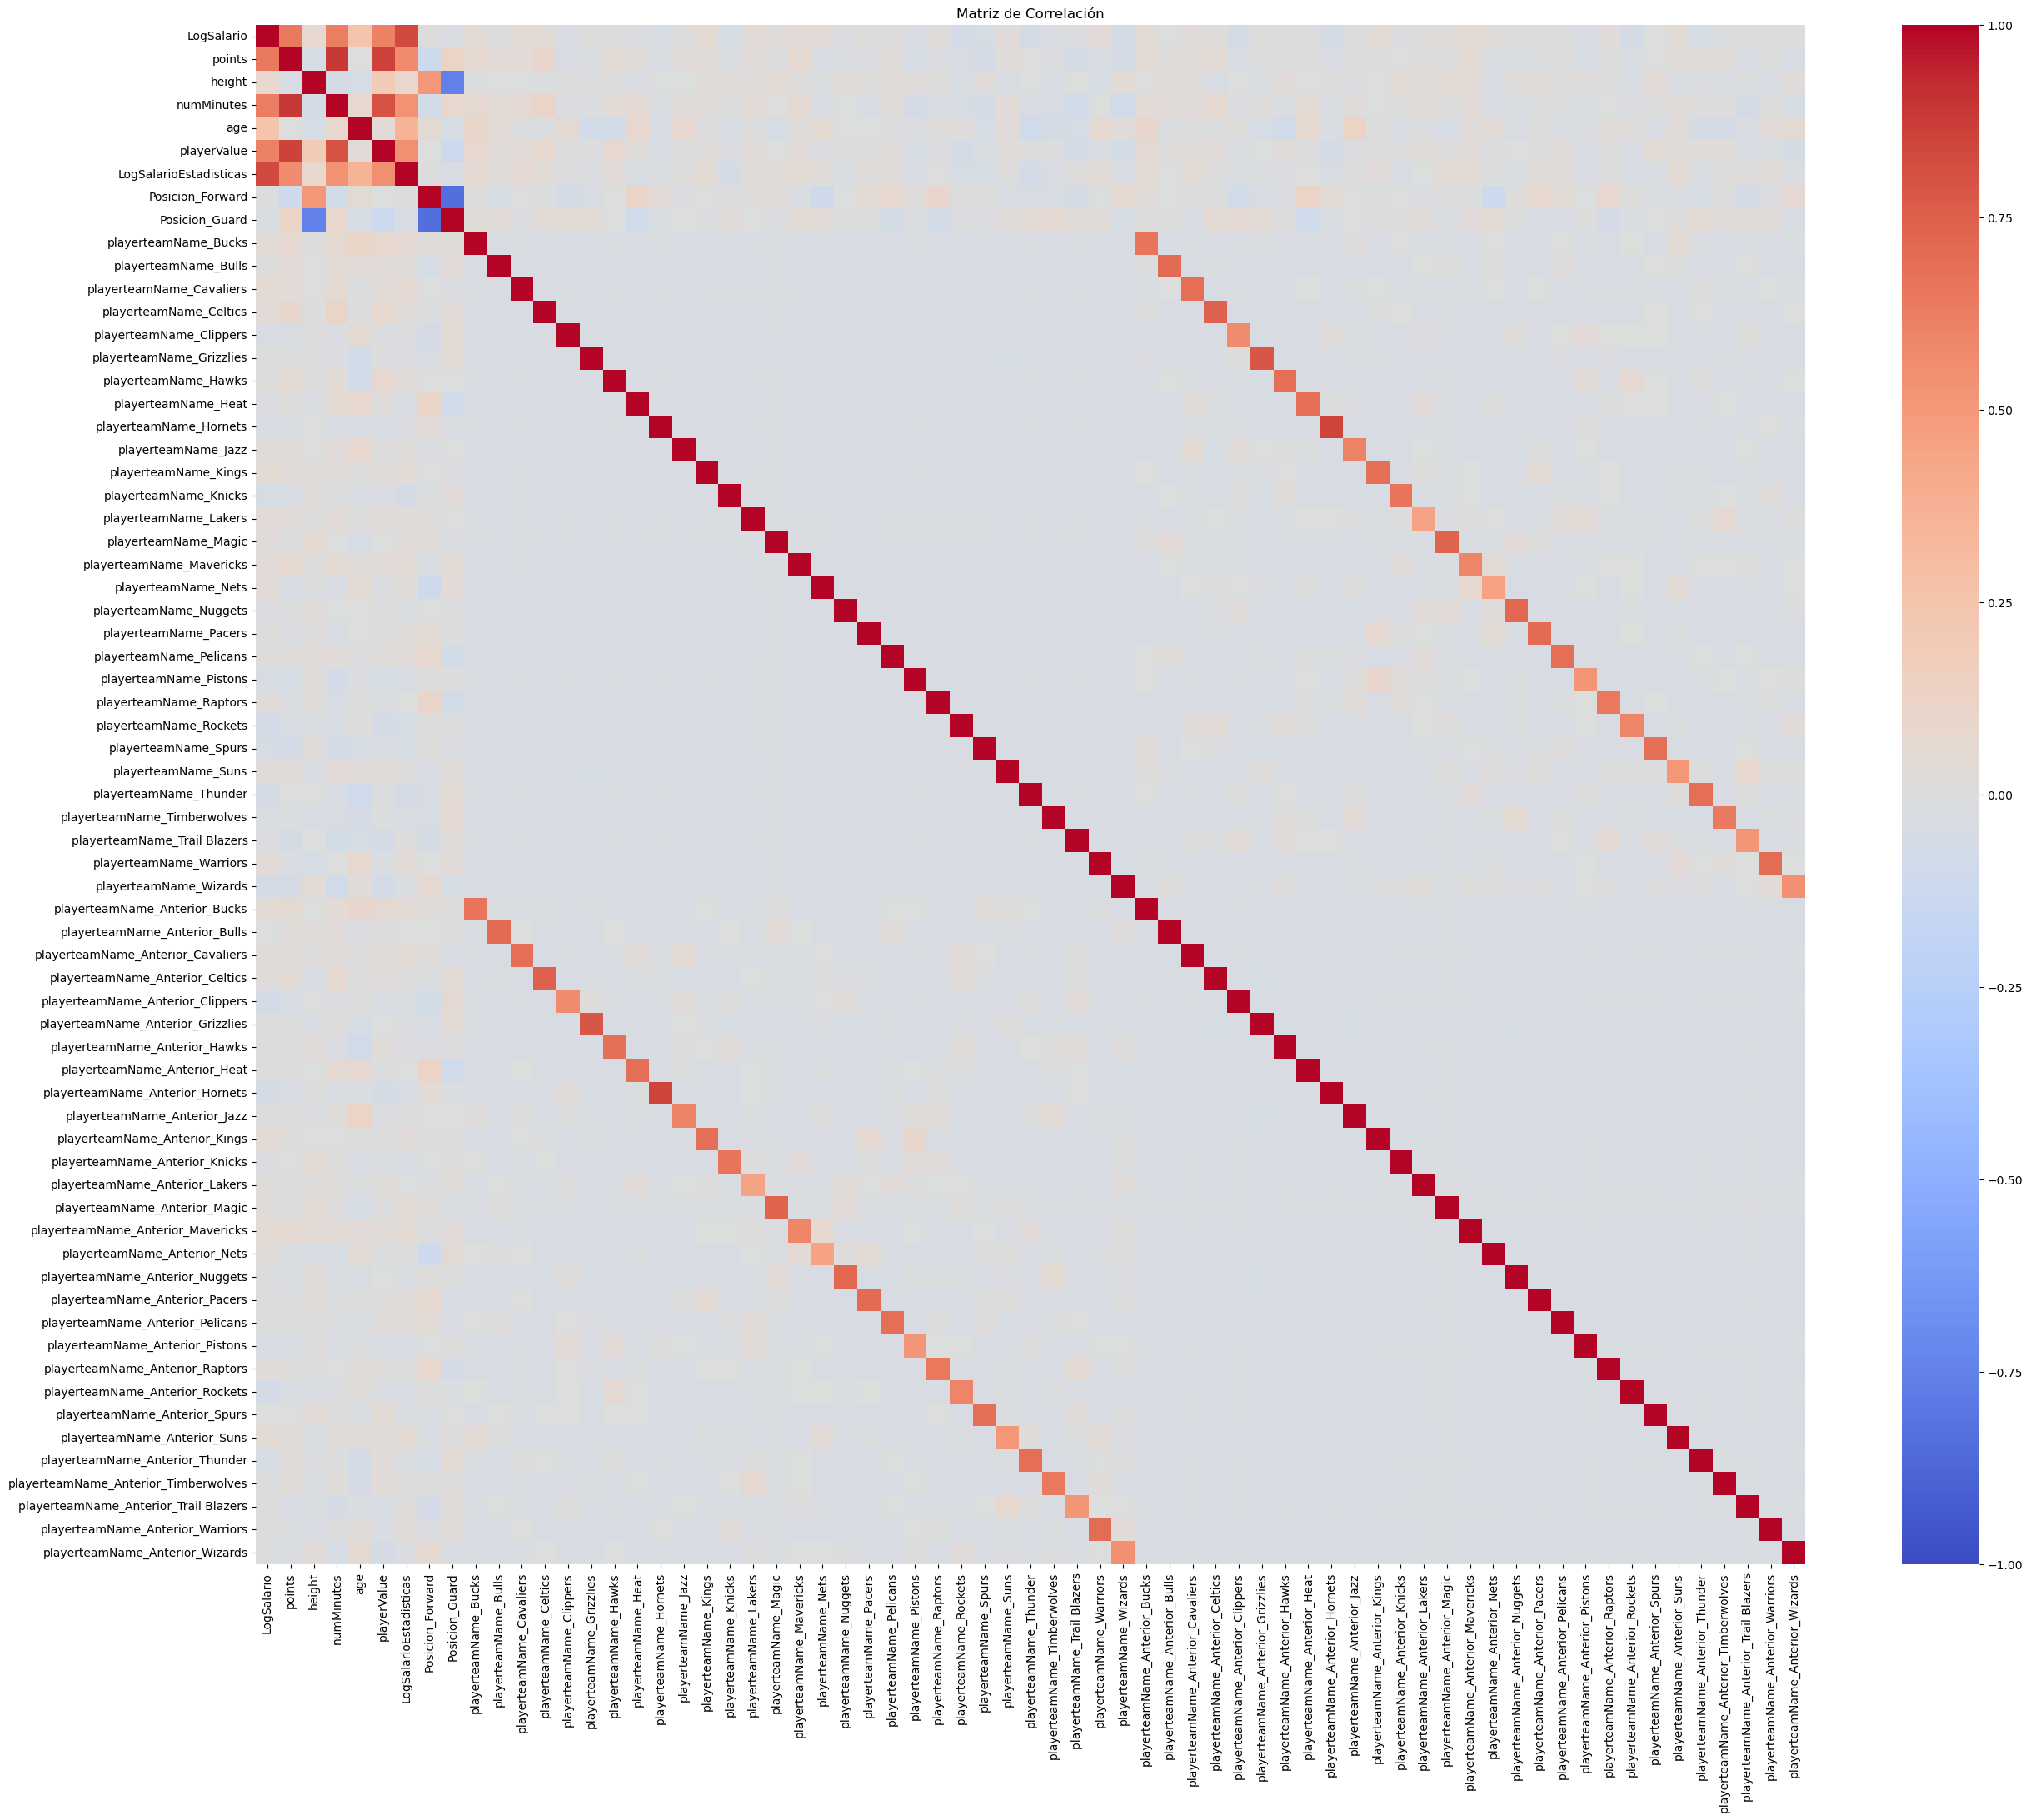

In [90]:
# Crear un mapa de calor para la matriz de correlación
plt.figure(figsize=(30, 24))  # Tamaño de la figura
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Mostrar el gráfico
plt.title("Matriz de Correlación")
plt.show()

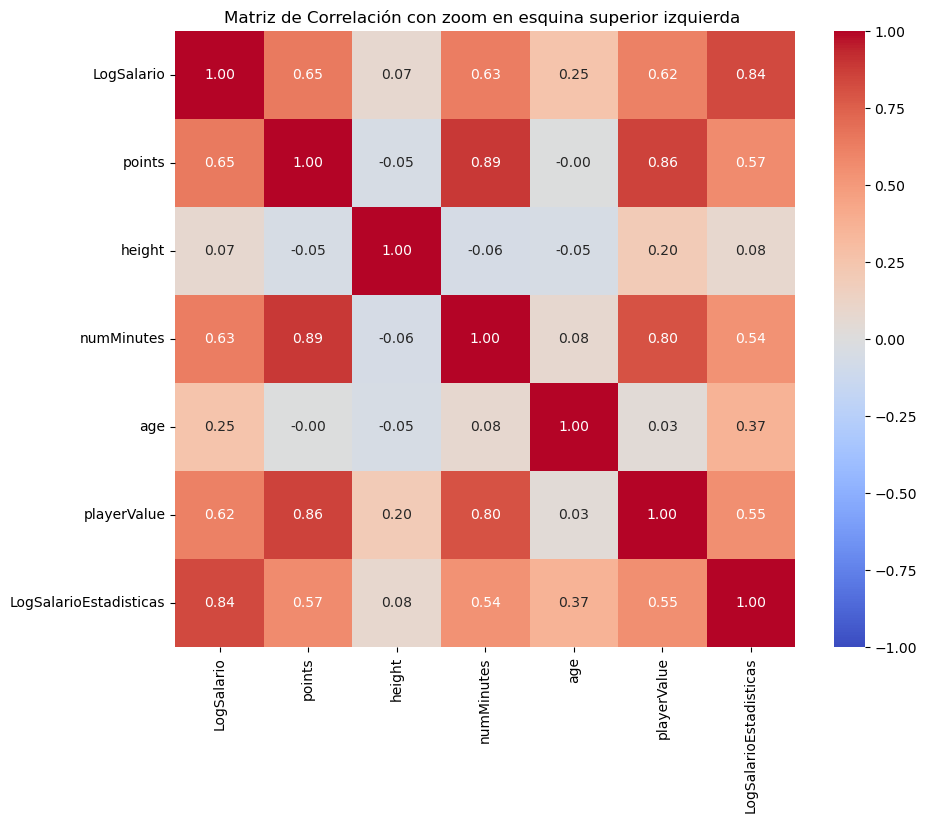

In [91]:

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix.iloc[0:7,0:7], annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title("Matriz de Correlación con zoom en esquina superior izquierda ")
plt.show()

Con esta matriz mostramos la relación lineal entre cada par de variables, y observamos cuales tienen más peso.

# Cálculo del p-valor

Como otra métrica calculamos el p-valor, para conocer el peso de cada una de las variables en un modelo de regresión lineal.

In [103]:
# Agregar una constante (intercepto) a X
XConst = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(Y, XConst).fit()

# Obtener los p-valores
pValues = model.pvalues

# Mostrar solo los p-valores menores a 0.05
pValues_below_0_05 = pValues[pValues < 0.05]

print("P-valores menores a 0.05:")
print(p_values_below_0_05)

P-valores menores a 0.05:
const                                5.491107e-08
points                               2.910000e-03
height                               7.617769e-07
numMinutes                           4.830802e-16
age                                  7.488940e-08
LogSalarioEstadisticas               1.230066e-02
Posicion_Guard                       7.211972e-08
playerteamName_Bucks                 2.115571e-02
playerteamName_Bulls                 8.109973e-08
playerteamName_Cavaliers             1.614939e-02
playerteamName_Celtics               1.165152e-02
playerteamName_Grizzlies             1.083194e-03
playerteamName_Hawks                 2.788346e-05
playerteamName_Heat                  5.275296e-09
playerteamName_Hornets               9.279210e-03
playerteamName_Magic                 4.649738e-02
playerteamName_Mavericks             2.398545e-02
playerteamName_Raptors               1.995504e-05
playerteamName_Suns                  2.338002e-02
playerteamName_Timberwol

El p-valor indica la probabilidad de que el coeficiente asociado a cada variable sea igual a cero (es decir, que la variable no sea significativa). Un p-valor pequeño (generalmente < 0.05) sugiere que la variable tiene un impacto significativo en la predicción.

# Cálculo del VIF

Por último, antes de hacer varias pruebas con el modelo de regresión lineal, que es el que necesitamos para poder predecir salarios, calculamos el VIF.

El VIF mide la colinealidad de las variables predictoras en un modelo de regresión. Un VIF alto (por encima de 10) sugiere que las variables están altamente correlacionadas entre sí y pueden estar afectando la estabilidad del modelo.

In [397]:
XConst2 = add_constant(X)

# Calculamos el VIF para cada una de las variables
vifData = pd.DataFrame()
vifData["Variable"] = XConst2.columns
vifData["VIF"] = [variance_inflation_factor(X_const2.values, i) for i in range(XConst2.shape[1])]

print("VIF para cada variable:")
print(vifData)

print("VIF mayor a 10 (alta colinealidad):")
print(vifData[vifData['VIF']>10])

VIF para cada variable:
                                 Variable         VIF
0                                   const  604.562540
1                                  points    8.446448
2                                  height    3.058368
3                              numMinutes    5.588502
4                                     age    1.481852
..                                    ...         ...
63   playerteamName_Anterior_Timberwolves    3.156845
64  playerteamName_Anterior_Trail Blazers    2.423100
65       playerteamName_Anterior_Warriors    3.574043
66        playerteamName_Anterior_Wizards    2.775950
67                             LogSalario    4.250319

[68 rows x 2 columns]
VIF mayor a 10 (alta colinealidad):
  Variable        VIF
0    const  604.56254


Con esto observamos la colinealidad entre las variables:

In [400]:
print("VIF mayor a 10 (alta colinealidad):")
print(vifData[vifData['VIF']>10])

VIF mayor a 10 (alta colinealidad):
  Variable        VIF
0    const  604.56254


# Modelo de regresión lineal

Primero dividimos nuestro data set filtrado en training y test. 

Vamos primero a hacer el modelo con las variables que intuitivamente pensamos que pueden funcionar viendo el mapa de calor de la matriz de correlación

In [365]:
X1 = X.loc[:,['age','points','playerValue','numMinutes','LogSalarioEstadisticas']]

Hacemos un scatterplot con cada una de las variables y les añadimos una linea de tendencia

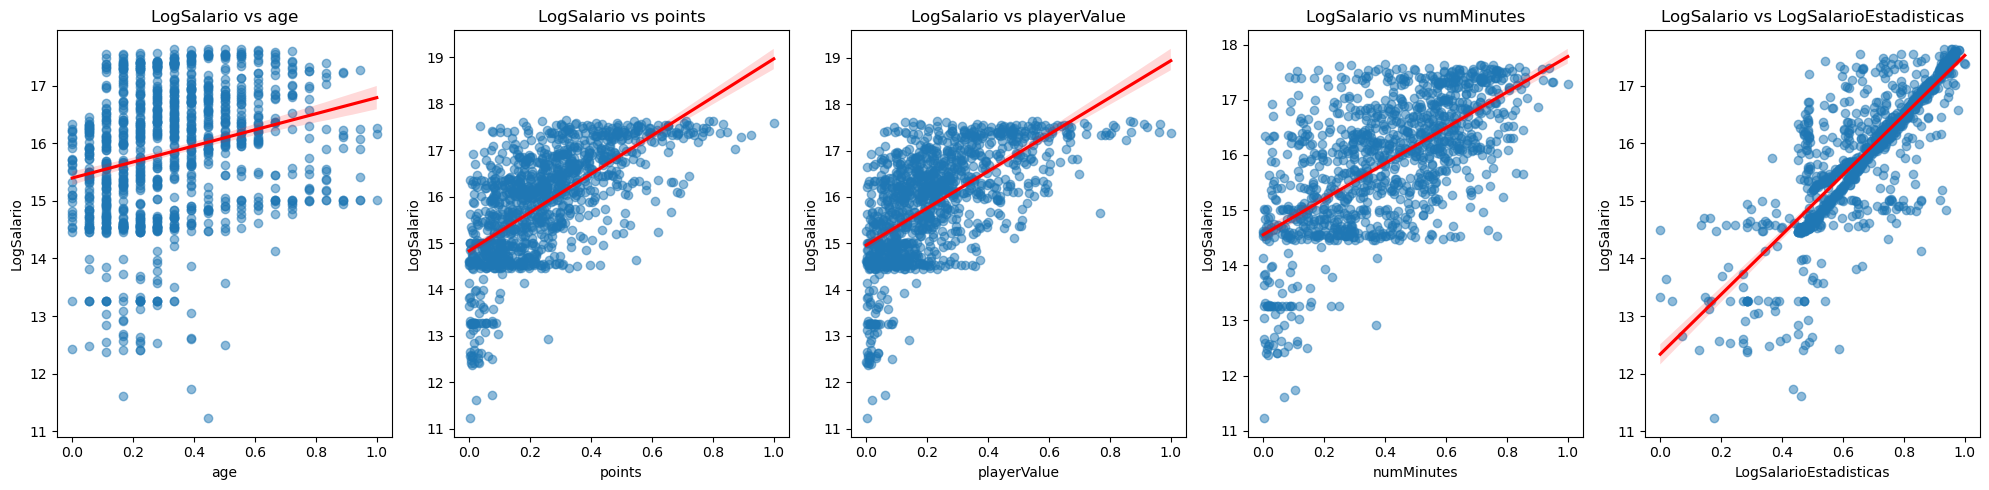

In [419]:
# Lista de variables de X
features = ['age', 'points', 'playerValue', 'numMinutes', 'LogSalarioEstadisticas']

# Crear figuras en una sola fila
fig, axes = plt.subplots(1, len(features), figsize=(20,5))

# Recorremos  cada variable X y graficamos un scatter plot con línea de tendencia
for i, feature in enumerate(features):
    sns.regplot(x=dfFinalEnc[feature], y=dfFinalEnc['LogSalario'], ax=axes[i], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('LogSalario')
    axes[i].set_title(f'LogSalario vs {feature}')

plt.tight_layout()
plt.show()


Viendo estas graficas, podemos intentar sacar una linea polinómica de grado 2 o logarítmica que parece poder acercarse más a predecir correctamente. Vamos a intentar representarlas para ver si se ajustan más.

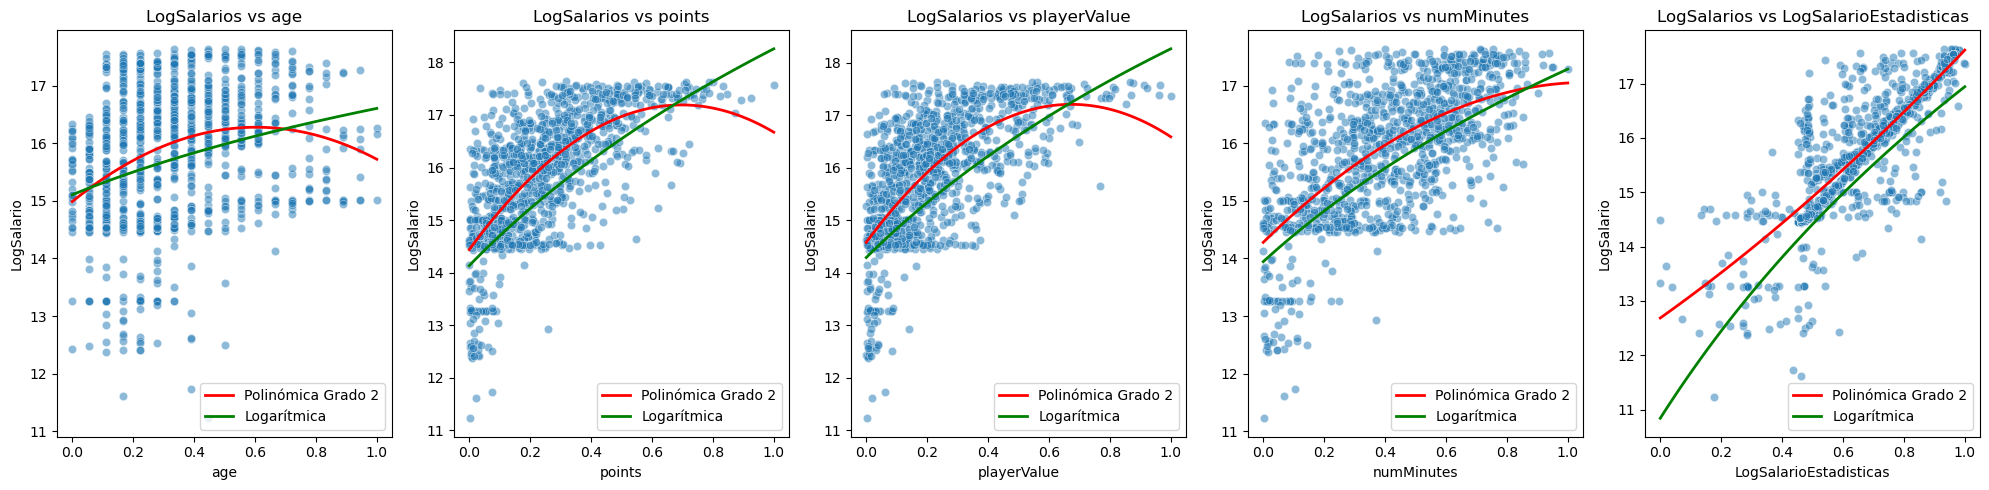

In [437]:
# Crear figura con múltiples gráficos
fig, axes = plt.subplots(1, len(features), figsize=(20, 5))

for i, feature in enumerate(features):
    # Datos
    X = dfFinalEnc[feature].values.reshape(-1, 1)  # Convertir a matriz columna
    y = dfFinalEnc['LogSalario'].values

    # Regresión Polinómica (Grado 2)
    poly2 = PolynomialFeatures(degree=2)
    XPoly = poly2.fit_transform(X)  
    modelPoly = LinearRegression().fit(XPoly, y)

    # Regresión Logarítmica (log(X) en vez de X)
    XLog = np.log1p(X+ 0.1)  # log(1 + X) para evitar problemas con valores 0
    modelLog = LinearRegression().fit(XLog, y)

    # Generar valores suavizados para la curva
    XRange = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    XRangePoly = poly2.transform(XRange)
    XRangeLog = np.log1p(XRange)

    # Predicciones
    yPred_poly = modelPoly.predict(XRangePoly)
    yPred_log = modelLog.predict(XRangeLog)

    # Graficar scatter plot
    sns.scatterplot(x=dfFinalEnc[feature], y=dfFinalEnc['LogSalario'], ax=axes[i], alpha=0.5)

    # Graficar regresión polinómica (en rojo)
    axes[i].plot(XRange, yPred_poly, color='red', label='Polinómica Grado 2', linewidth=2)

    # Graficar regresión logarítmica (en verde)
    axes[i].plot(XRange, yPred_log, color='green', label='Logarítmica', linewidth=2)

    # Etiquetas y título
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('LogSalario')
    axes[i].set_title(f'LogSalarios vs {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Vamos a probar a entrenar un modelo de regresión lineal con estos features de grado 1 (lineal) y de grado 2 para ver que resultado nos da

# Entrenamiento y predicción modelo de regresión lineal (grado 1)

In [444]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X1, Y,
    train_size = 0.80,
    test_size = 0.20
)

In [446]:
XTrain.shape, XTest.shape

((904, 5), (226, 5))

In [448]:
yTrain.shape, yTest.shape

((904,), (226,))

In [450]:
lm1 = LinearRegression()
lm1.fit(XTrain, yTrain)

LinearRegression()

In [452]:
# coeficientes
lm1.coef_

array([-0.07949314,  0.78271793,  0.28141886,  0.5539287 ,  4.30718019])

In [454]:
# intercepto
lm1.intercept_

12.489992078194835

Ahora predecimos y deshacemos la transformación logarítmica

In [457]:
yPred = lm1.predict(XTest)
yPred = np.exp(yPred)
yTest = np.exp(yTest)

Ahora vemos la medida de error del modelo

In [460]:
mae1 = mean_absolute_error(yTest, yPred)
mse1 = mean_squared_error(yTest, yPred)
rmse1 = np.sqrt(mse1)
mape1 = np.mean(np.abs((yTest - yPred) / yTest)) * 100  # En porcentaje
r21 = r2_score(yTest, yPred)

print("\n🔹 Evaluación en Test Set:")
print(f"MAE: {mae1:.2f}, MSE: {mse1:.2f}, RMSE: {rmse1:.2f}, R²: {r21:.2f}")



🔹 Evaluación en Test Set:
MAE: 4403857.31, MSE: 49675813276117.64, RMSE: 7048107.07, R²: 0.65


El error es un poco alto con estos features y funciona un poco regular, podría mejorarse, vamos a probar a utilizar un polinomio de grado 2 y 3 con los mismos features para comprobar si se ajusta mejor.

# Entrenamiento y predicción modelo de regresión lineal (grado 2 y 3)

In [475]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X1, Y,
    train_size = 0.80,
    test_size = 0.20
)
# Transformacion en polinomio (transformar X para incluir términos polinómicos (grado 2)
poly2 = PolynomialFeatures(degree=2) 
XTrainPoly2 = poly2.fit_transform(XTrain)
XTestPoly2 = poly2.transform(XTest)

# Ajustamos la regresion
modelo = LinearRegression()
modelo.fit(XTrainPoly2, yTrain)

# Vamos a hacer predicciones sobre ambos conjuntos (para ver también la medida de error)
yPredTrain = modelo.predict(XTrainPoly2)
yPred = modelo.predict(XTestPoly2)

#Deshacemos la transformación logarítmica
yPredTrain = np.exp(yPredTrain)
yTrain = np.exp(yTrain)

yPred = np.exp(yPred)
yTest = np.exp(yTest)

# Evaluamos
maeTrain = mean_absolute_error(yTrain, yPredTrain)
mseTrain = mean_squared_error(yTrain, yPredTrain)
rmseTrain = np.sqrt(mseTrain)
r2Train = r2_score(yTrain, yPredTrain)

maeTest = mean_absolute_error(yTest, yPred)
mseTest = mean_squared_error(yTest, yPred)
rmseTest = np.sqrt(mseTest)
r2Test = r2_score(yTest, yPred)


In [477]:
# Mostramos los datos de los errores
print("🔹 Evaluación en Training Set grado 2:")
print(f"MAE: {maeTrain:.2f}, MSE: {mseTrain:.2f}, RMSE: {rmseTrain:.2f}, R²: {r2Train:.2f}")

print("\n🔹 Evaluación en Test Set grado 2:")
print(f"MAE: {maeTest:.2f}, MSE: {mseTest:.2f}, RMSE: {rmseTest:.2f}, R²: {r2Test:.2f}")

🔹 Evaluación en Training Set grado 2:
MAE: 3327687.93, MSE: 29706159521784.59, RMSE: 5450335.73, R²: 0.78

🔹 Evaluación en Test Set grado 2:
MAE: 3454420.77, MSE: 29432262006046.73, RMSE: 5425150.87, R²: 0.82


Nuestro error ha mejorado, vamos a probar por ultima vez con un polinomio de grado 3.

In [469]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X1, Y,
    train_size = 0.80,
    test_size = 0.20

)
# Transformacion en polinomio (transformar X para incluir términos polinómicos (grado 3)
poly3 = PolynomialFeatures(degree=3) 
XTrainPoly3 = poly3.fit_transform(XTrain)
XTestPoly3 = poly3.transform(XTest)

# Ajustamos la regresion
modelo = LinearRegression()
modelo.fit(XTrainPoly3, yTrain)

# Vamos a hacer predicciones sobre ambos conjuntos (para ver también la medida de error)
yPredTrain = modelo.predict(XTrainPoly3)
yPred = modelo.predict(XTestPoly3)

#Deshacemos la transformación logarítmica
yPredTrain = np.exp(yPredTrain)
yTrain = np.exp(yTrain)

yPred = np.exp(yPred)
yTest = np.exp(yTest)

# Evaluamos
maeTrain = mean_absolute_error(yTrain, yPredTrain)
mseTrain = mean_squared_error(yTrain, yPredTrain)
rmseTrain = np.sqrt(mseTrain)
r2Train = r2_score(yTrain, yPredTrain)

maeTest = mean_absolute_error(yTest, yPred)
mseTest = mean_squared_error(yTest, yPred)
rmseTest = np.sqrt(mseTest)
r2Test = r2_score(yTest, yPred)


In [471]:
# Mostramos los datos de los errores
print("🔹 Evaluación en Training Set grado 3:")
print(f"MAE: {maeTrain:.2f}, MSE: {mseTrain:.2f}, RMSE: {rmseTrain:.2f}, R²: {r2Train:.2f}")

print("\n🔹 Evaluación en Test Set grado 3:")
print(f"MAE: {maeTest:.2f}, MSE: {mseTest:.2f}, RMSE: {rmseTest:.2f}, R²: {r2Test:.2f}")

🔹 Evaluación en Training Set grado 3:
MAE: 3336958.41, MSE: 28513491414274.74, RMSE: 5339802.56, R²: 0.80

🔹 Evaluación en Test Set grado 3:
MAE: 3492750.71, MSE: 30735097339756.48, RMSE: 5543924.36, R²: 0.74


El error no se mueve mucho así que vamos a probar ahora con un selector que nos escoja los features que sean más representativos, pero manteniendo el grado 2, ya que es menos complejo (más interpretabilidad) y el error es un poco mejor

# Prueba con estimador y RFE

Creamos un estimador lineal primero

In [716]:
estimator = SVR(kernel="linear")

Volvemos a definir X e Y para que sea previo a las predicciones y las transformaciones de las regresiones sin RFE 

In [719]:
X = dfFinalEnc.iloc[:,1:]
Y = dfFinalEnc.loc[:,'LogSalario']
X

,points,height,numMinutes,age,playerValue,LogSalarioEstadisticas,Posicion_Forward,Posicion_Guard,playerteamName_Bucks,playerteamName_Bulls,...,playerteamName_Anterior_Pistons,playerteamName_Anterior_Raptors,playerteamName_Anterior_Rockets,playerteamName_Anterior_Spurs,playerteamName_Anterior_Suns,playerteamName_Anterior_Thunder,playerteamName_Anterior_Timberwolves,playerteamName_Anterior_Trail Blazers,playerteamName_Anterior_Warriors,playerteamName_Anterior_Wizards
13,0.176509,0.333333,0.247530,0.444444,0.127119,0.965397,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.417323,0.866667,0.839252,0.611111,0.716286,0.969084,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15,0.704724,0.666667,0.808278,0.555556,0.966102,0.967519,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.484580,0.066667,0.542857,0.277778,0.362564,0.965397,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.000000,0.466667,0.938318,0.222222,0.911938,0.965397,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,0.075787,0.000000,0.155941,0.166667,0.086957,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,0.189633,0.266667,0.466756,0.111111,0.046426,0.514391,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1169,0.334974,0.066667,0.503872,0.555556,0.319455,0.842992,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1170,0.075131,0.400000,0.145794,0.166667,0.053427,0.133074,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [764]:
#Volvemos a incluir todos los features de dfFinalEnc para que el estimador decida cuales son más relevantes
XTrain, XTest, yTrain, yTest = train_test_split(
    X, Y,
    train_size = 0.80,
    test_size = 0.20
)

In [766]:
XTrain.shape, XTest.shape

((904, 66), (226, 66))

In [768]:
yTrain.shape, yTest.shape

((904,), (226,))

Con el estimador y el RFE seleccionamos los features que considere más relevantes

In [771]:
selector = RFE(
    estimator,
    n_features_to_select=7 #Probamos con 5 features
) 
selector = selector.fit(XTrain, yTrain)

In [772]:
#Nos indica las columnas que debemos seleccionar
selector.support_

array([ True, False,  True, False,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False])

In [773]:
XTrainFinal = XTrain.loc[:,selector.support_]
XTrainFinal.head()

,points,numMinutes,playerValue,LogSalarioEstadisticas,playerteamName_Clippers,playerteamName_Anterior_Clippers,playerteamName_Anterior_Thunder
906,0.261811,0.356475,0.225129,0.469725,0.0,0.0,0.0
691,0.272966,0.681175,0.196389,0.548347,0.0,0.0,0.0
709,0.305446,0.646729,0.312085,0.486999,1.0,1.0,0.0
303,0.008530,0.012817,0.011791,0.228171,0.0,0.0,0.0
606,0.563976,0.684913,0.616802,0.966909,0.0,0.0,0.0


Hemnos provado con distintas columnas a seleccionar y, según aumentamos el numero, parece que el equipo en el que va a jugar el jugador y en el que ha jugado esa temporada, son más relevantes que la edad de los mismos 

In [775]:
lmRFE = LinearRegression()
lmRFE.fit(XTrainFinal, yTrain)

LinearRegression()

In [776]:
# Coeficientes
lmRFE.coef_

array([ 0.69076646,  0.66688335,  0.22270731,  4.30867168,  0.2038746 ,
       -0.36247853, -0.25337993])

In [782]:
# Interceptamos
lmRFE.intercept_

12.460364281224207

In [784]:
#Volvemos a deshacer la transformación logarítmica después de la prediccion

yPred = lmRFE.predict(XTest.loc[:,selector.support_])
yPred = np.exp(yPred)
yTest = np.exp(yTest)

Vemos las medidas de error

In [787]:
maeTest2 = mean_absolute_error(yTest, yPred)
mseTest2 = mean_squared_error(yTest, yPred)
rmseTest2 = np.sqrt(mseTest)
r2Test2 = r2_score(yTest, yPred)

print("\n🔹 Evaluación en Test Set lineal:")
print(f"MAE: {maeTest2:.2f}, MSE: {mseTest2:.2f}, RMSE: {rmseTest2:.2f}, R²: {r2Test2:.2f}")


🔹 Evaluación en Test Set lineal:
MAE: 4141938.52, MSE: 50338975754654.47, RMSE: 5425150.87, R²: 0.66


Al probar con varios features, el numero de features que mejor resultado (R²) obtiene, es cuando empleamos 5 o 6.

En definitiva el resultado es mejor cuando bien utilizamos las características que escogimos al principio con una regresión de grado 2 o con 5/6 features en una regresión lineal utilizando el Support Vector Regresion (SVR) y el Recurssive Feature Elimination(RFE)